In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('psu_banks.csv', index_col=['date'])
prices.head(10)

SBIN.NS  BANKBARODA.NS    CANBK.NS      PNB.NS  UNIONBANK.NS  \
date                                                                          
01-01-2018  307.100006     161.500000  360.700012  169.750000    144.899994   
02-01-2018  303.250000     157.949997  352.049988  166.399994    141.949997   
03-01-2018  302.850006     157.850006  352.799988  166.600006    143.149994   
04-01-2018  308.500000     163.899994  362.549988  176.449997    147.500000   
05-01-2018  306.350006     161.800003  364.850006  176.000000    145.300003   
08-01-2018  305.799988     161.649994  364.750000  175.699997    145.649994   
09-01-2018  304.299988     164.500000  364.700012  174.649994    144.100006   
10-01-2018  301.100006     162.500000  354.649994  170.649994    141.750000   
11-01-2018  302.200012     163.300003  355.500000  172.750000    138.800003   
12-01-2018  302.250000     163.000000  353.950012  174.199997    137.600006   

            BANKINDIA.NS  INDIANB.NS     IOB.NS  CENTRALBK.NS  MAHABANK.NS  
date                                                                        
01-01-2018    169.899994  377.149994  22.450001     74.699997    23.299999  
02-01-2018    167.300003  375.549988  22.350000     74.949997    22.950001  
03-01-2018    168.350006  373.200012  22.500000     75.900002    23.049999  
04-01-2018    174.649994  380.149994  23.049999     76.750000    23.600000  
05-01-2018    172.250000  379.250000  24.150000     76.050003    23.650000  
08-01-2018    170.399994  380.700012  23.950001     75.449997    23.549999  
09-01-2018    170.250000  377.950012  23.950001     74.900002    23.250000  
10-01-2018    165.000000  373.450012  23.549999     74.699997    22.750000  
11-01-2018    166.050003  370.899994  23.350000     74.699997    22.450001  
12-01-2018    162.649994  374.250000  23.500000     75.000000    22.400000

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

SBIN.NS  BANKBARODA.NS    CANBK.NS      PNB.NS  UNIONBANK.NS  \
date                                                                          
01-01-2018  307.100006     161.500000  360.700012  169.750000    144.899994   
02-01-2018  303.250000     157.949997  352.049988  166.399994    141.949997   
30-12-2020  276.899994      62.099998  129.350006   32.750000     31.950001   
31-12-2020  274.950012      61.450001  128.949997   33.049999     31.549999   

            BANKINDIA.NS  INDIANB.NS     IOB.NS  CENTRALBK.NS  MAHABANK.NS  
date                                                                        
01-01-2018    169.899994  377.149994  22.450001     74.699997    23.299999  
02-01-2018    167.300003  375.549988  22.350000     74.949997    22.950001  
30-12-2020     49.200001   87.050003  10.500000     13.750000    13.050000  
31-12-2020     48.700001   85.699997  10.700000     13.850000    13.050000

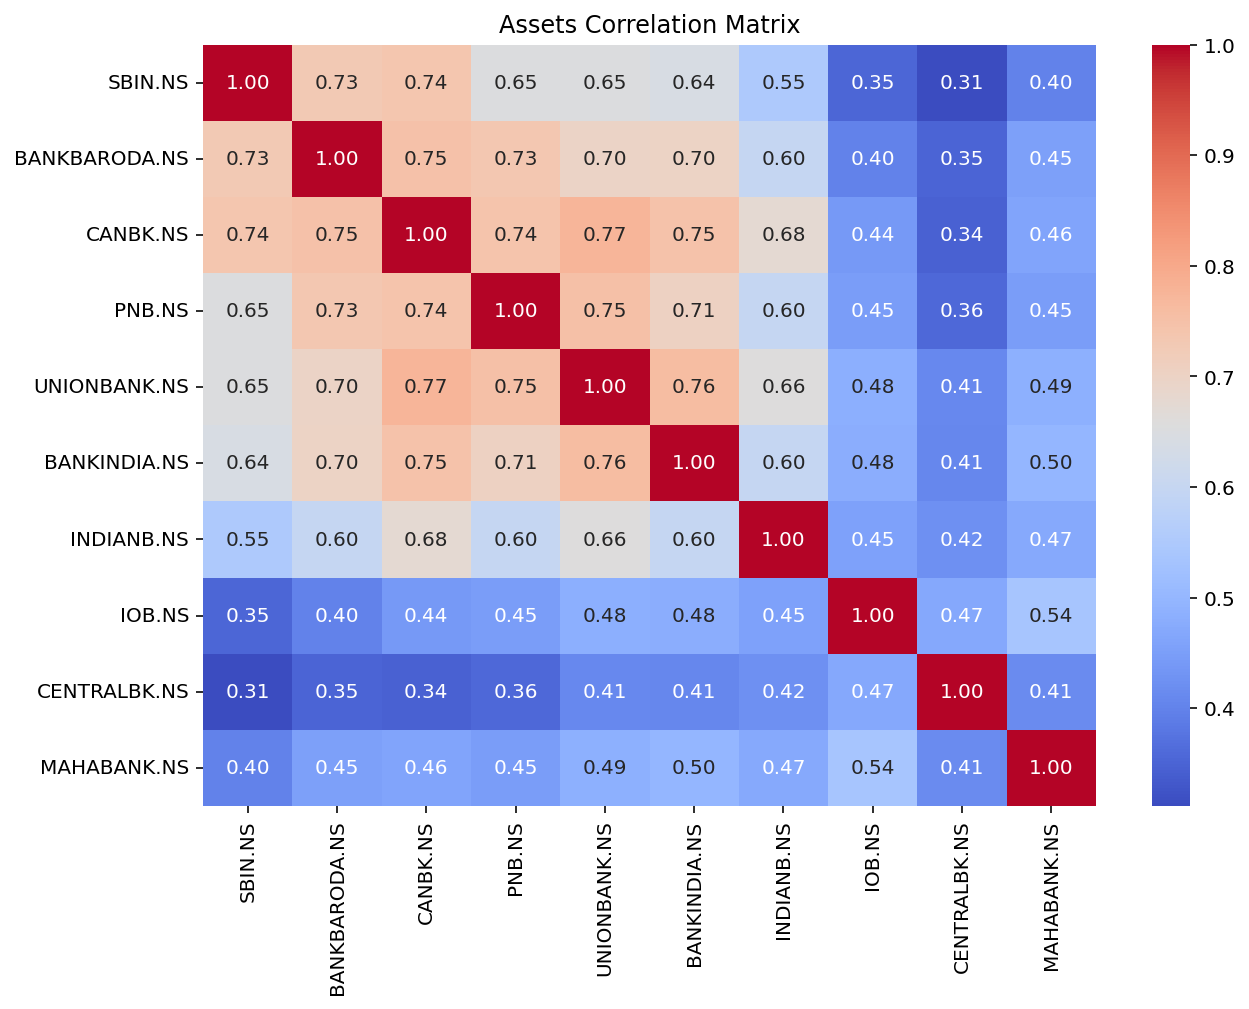

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('BANKBARODA.NS', 'UNIONBANK.NS'), ('BANKBARODA.NS', 'BANKINDIA.NS'), ('PNB.NS', 'UNIONBANK.NS'), ('PNB.NS', 'BANKINDIA.NS'), ('PNB.NS', 'INDIANB.NS'), ('PNB.NS', 'CENTRALBK.NS'), ('UNIONBANK.NS', 'BANKINDIA.NS'), ('UNIONBANK.NS', 'INDIANB.NS'), ('BANKINDIA.NS', 'INDIANB.NS')]


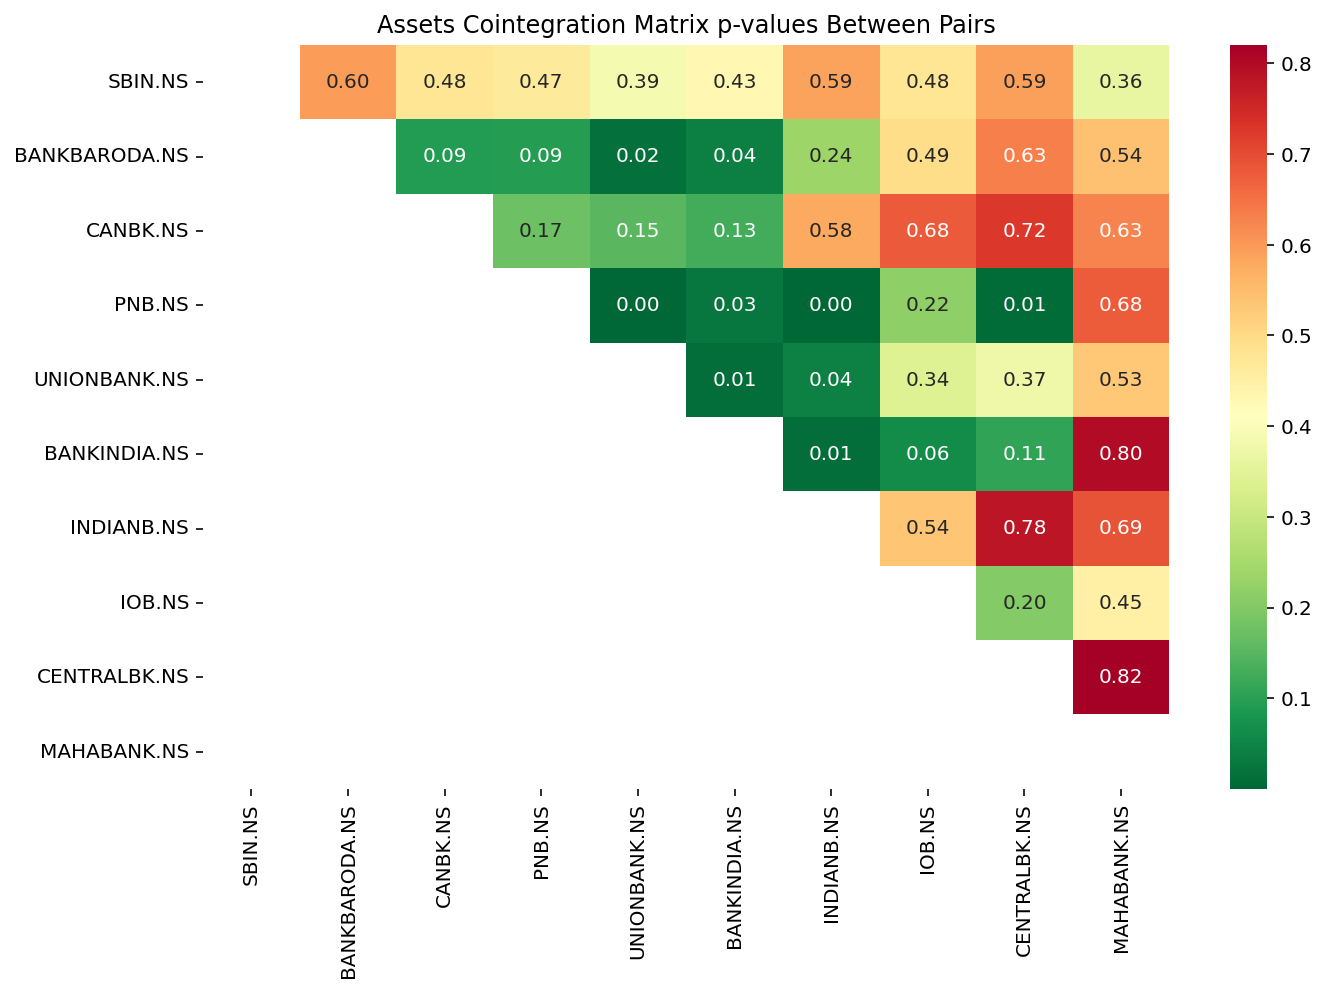

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'PNB.NS'
asset2 = 'INDIANB.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

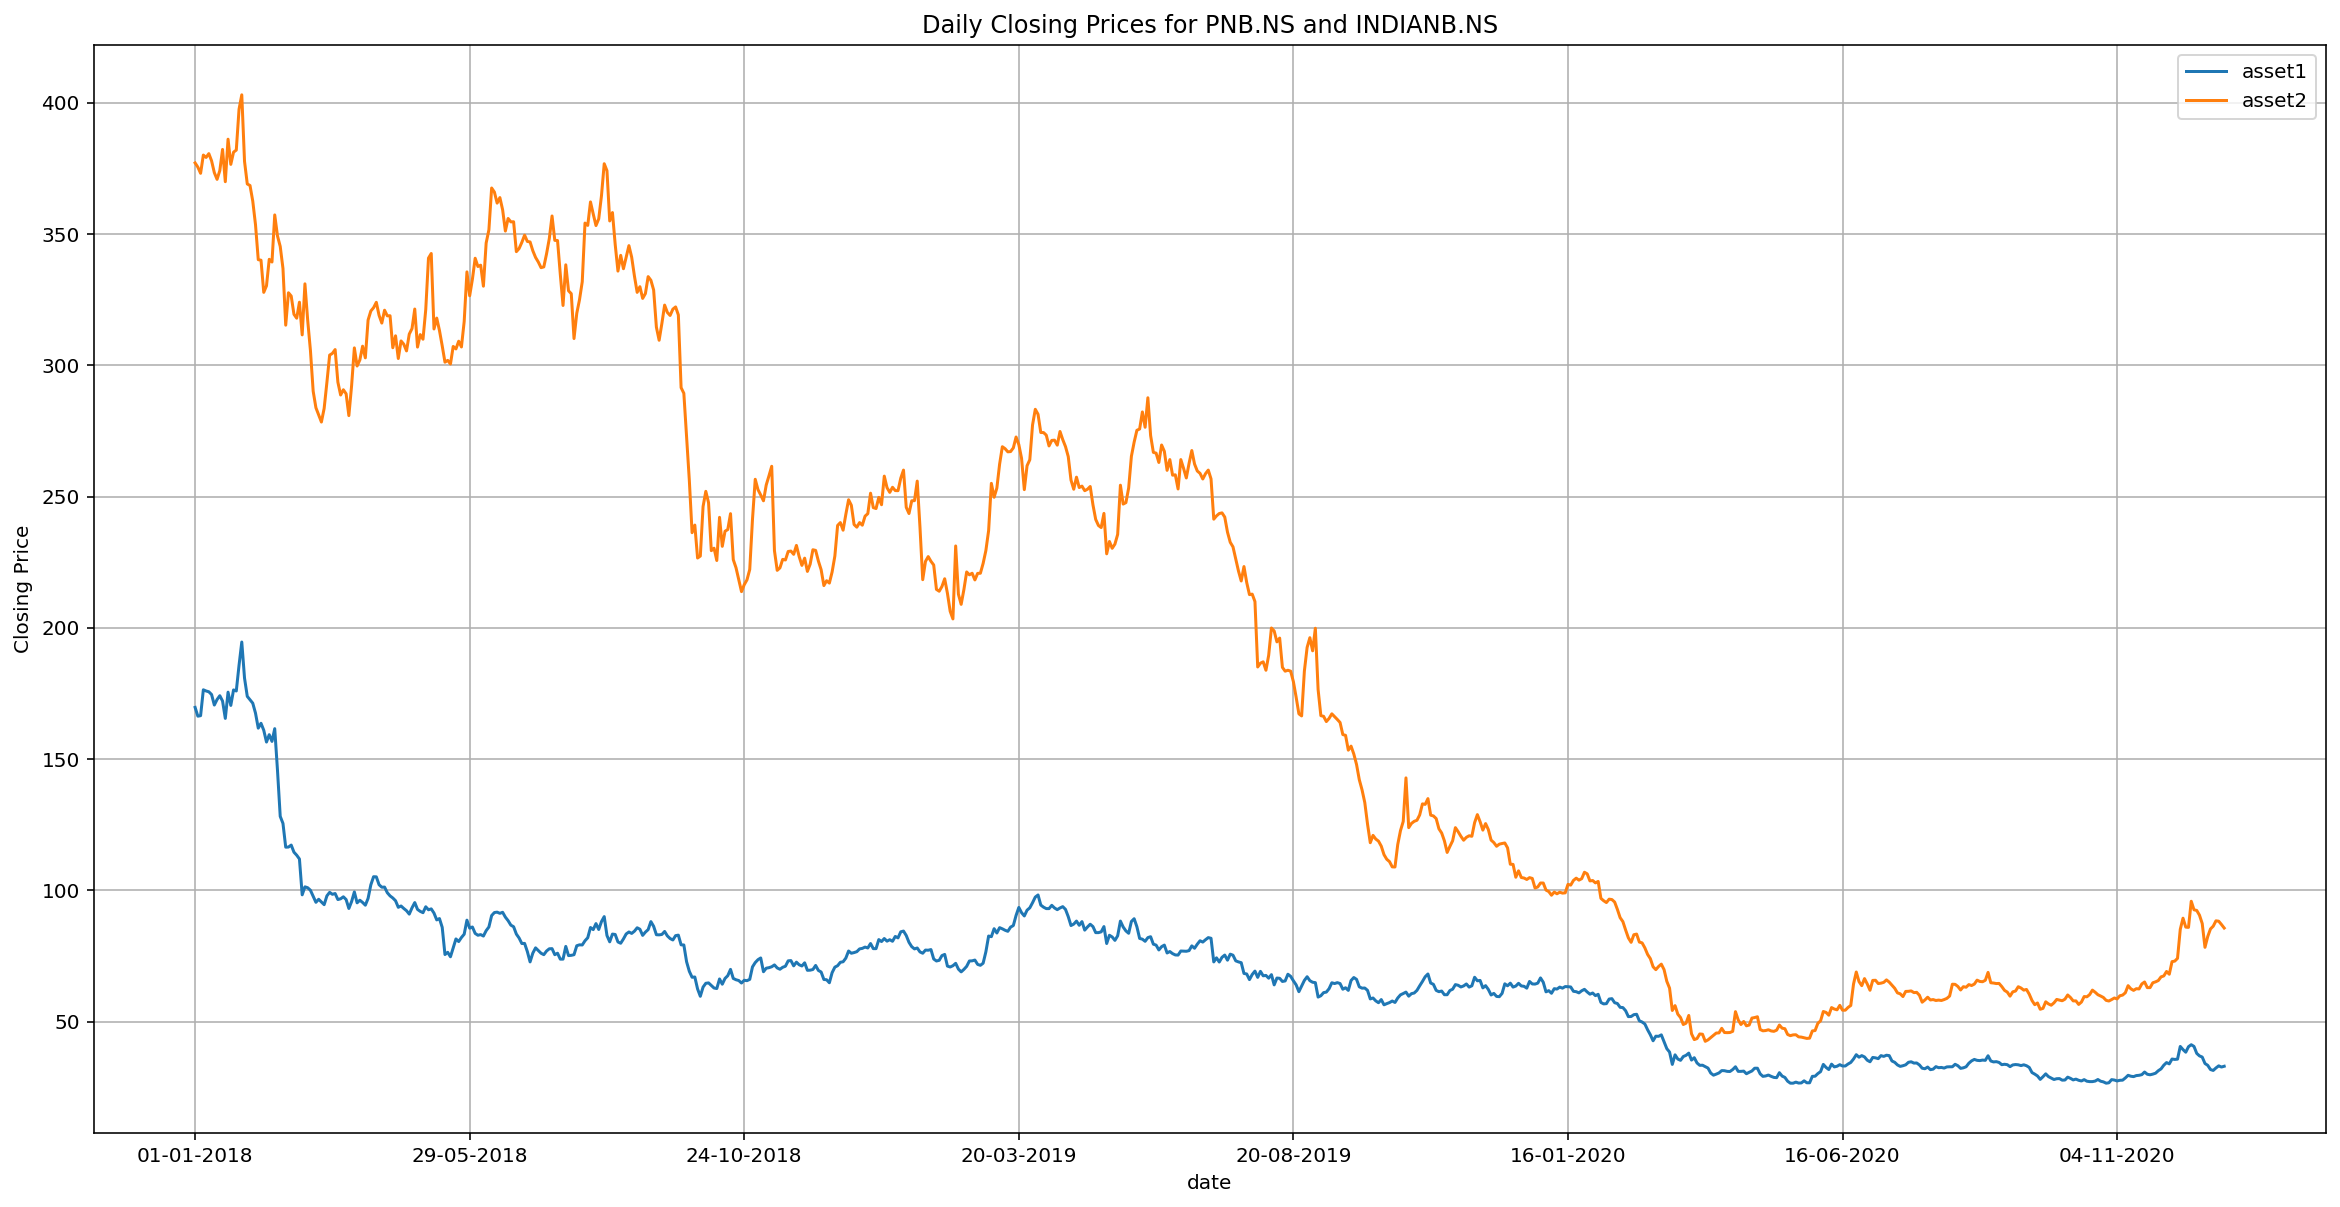

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                          1.065e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        00:01:38   Log-Likelihood:                         -4028.4
No. Observations:                 740   AIC:                                      8059.
Df Residuals:                     739   BIC:                                      8063.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         2.8462      0.028    103.198      0.000       2.792       2.900
==============================================================================
Omnibus:                       12.593   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.040
Skew:                           0.321   Prob(JB):                      0.00147
Kurtosis:                       2.899   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

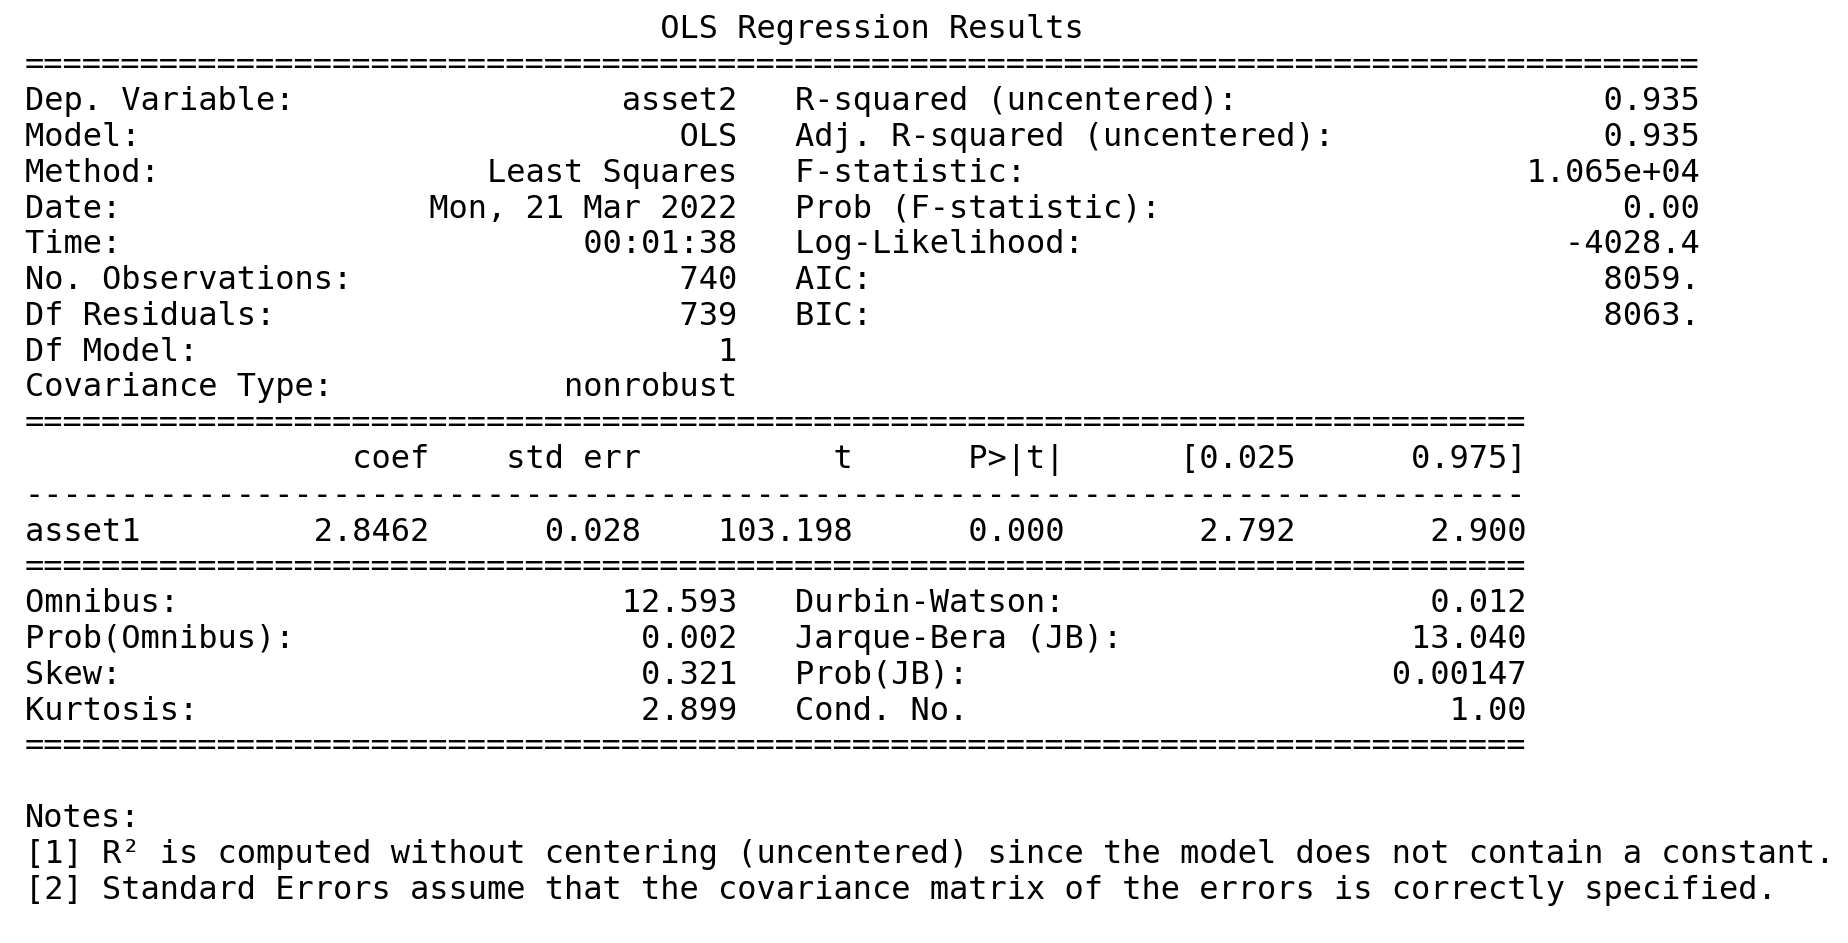

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  2.846160052446754


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

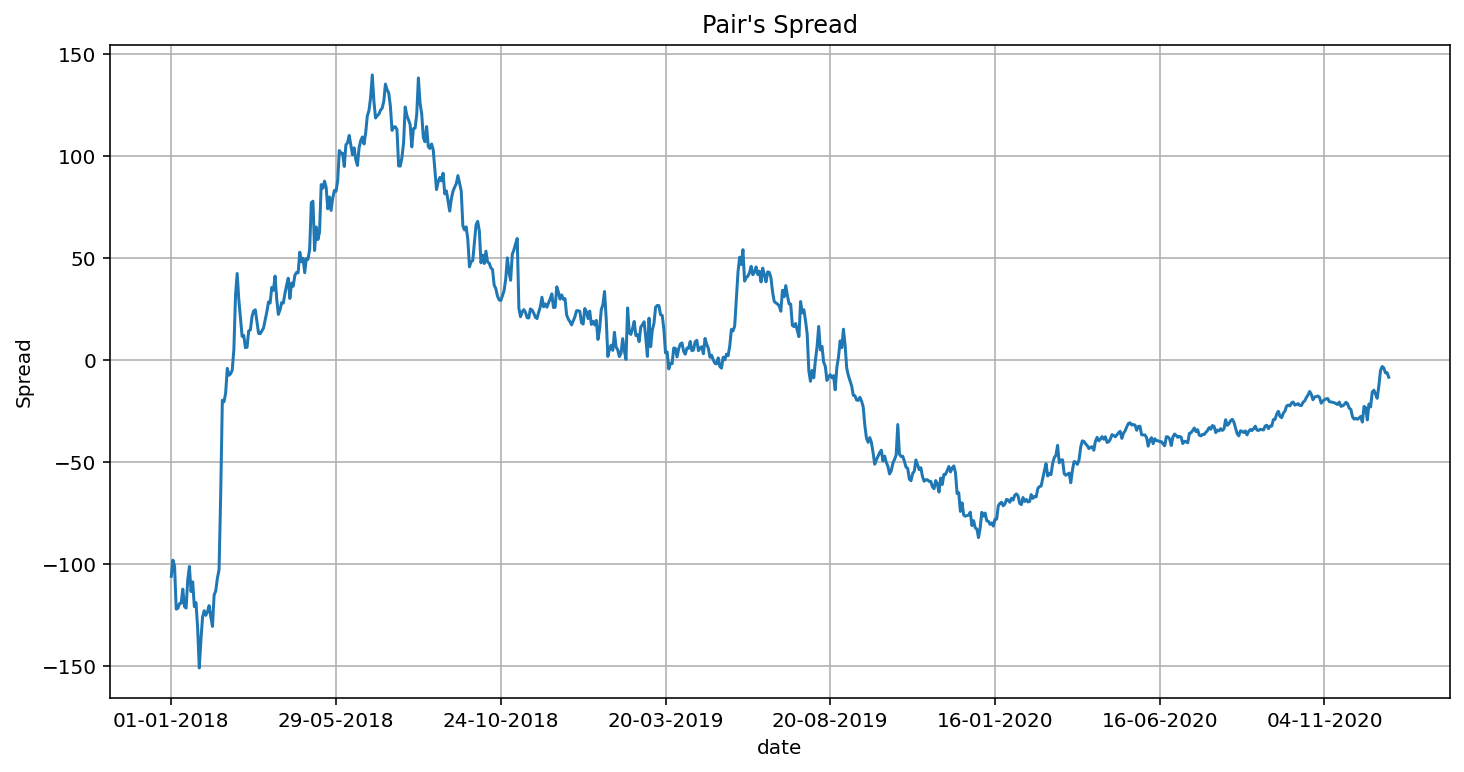

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.0537433948725194,
 0.2635165098143454,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 4747.685079550878)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -2.0537433948725194


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1     asset2
date                            
01-01-2021  34.799999  88.349998
04-01-2021  35.549999  88.699997
05-01-2021  35.599998  87.849998
06-01-2021  35.200001  87.750000
07-01-2021  35.450001  87.349998

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1     asset2         z  z upper limit  z lower limit
date                                                                    
01-01-2021  34.799999  88.349998  2.598503            1.0           -1.0
04-01-2021  35.549999  88.699997  2.787790            1.0           -1.0
05-01-2021  35.599998  87.849998  2.909762            1.0           -1.0
06-01-2021  35.200001  87.750000  2.797401            1.0           -1.0
07-01-2021  35.450001  87.349998  2.926285            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

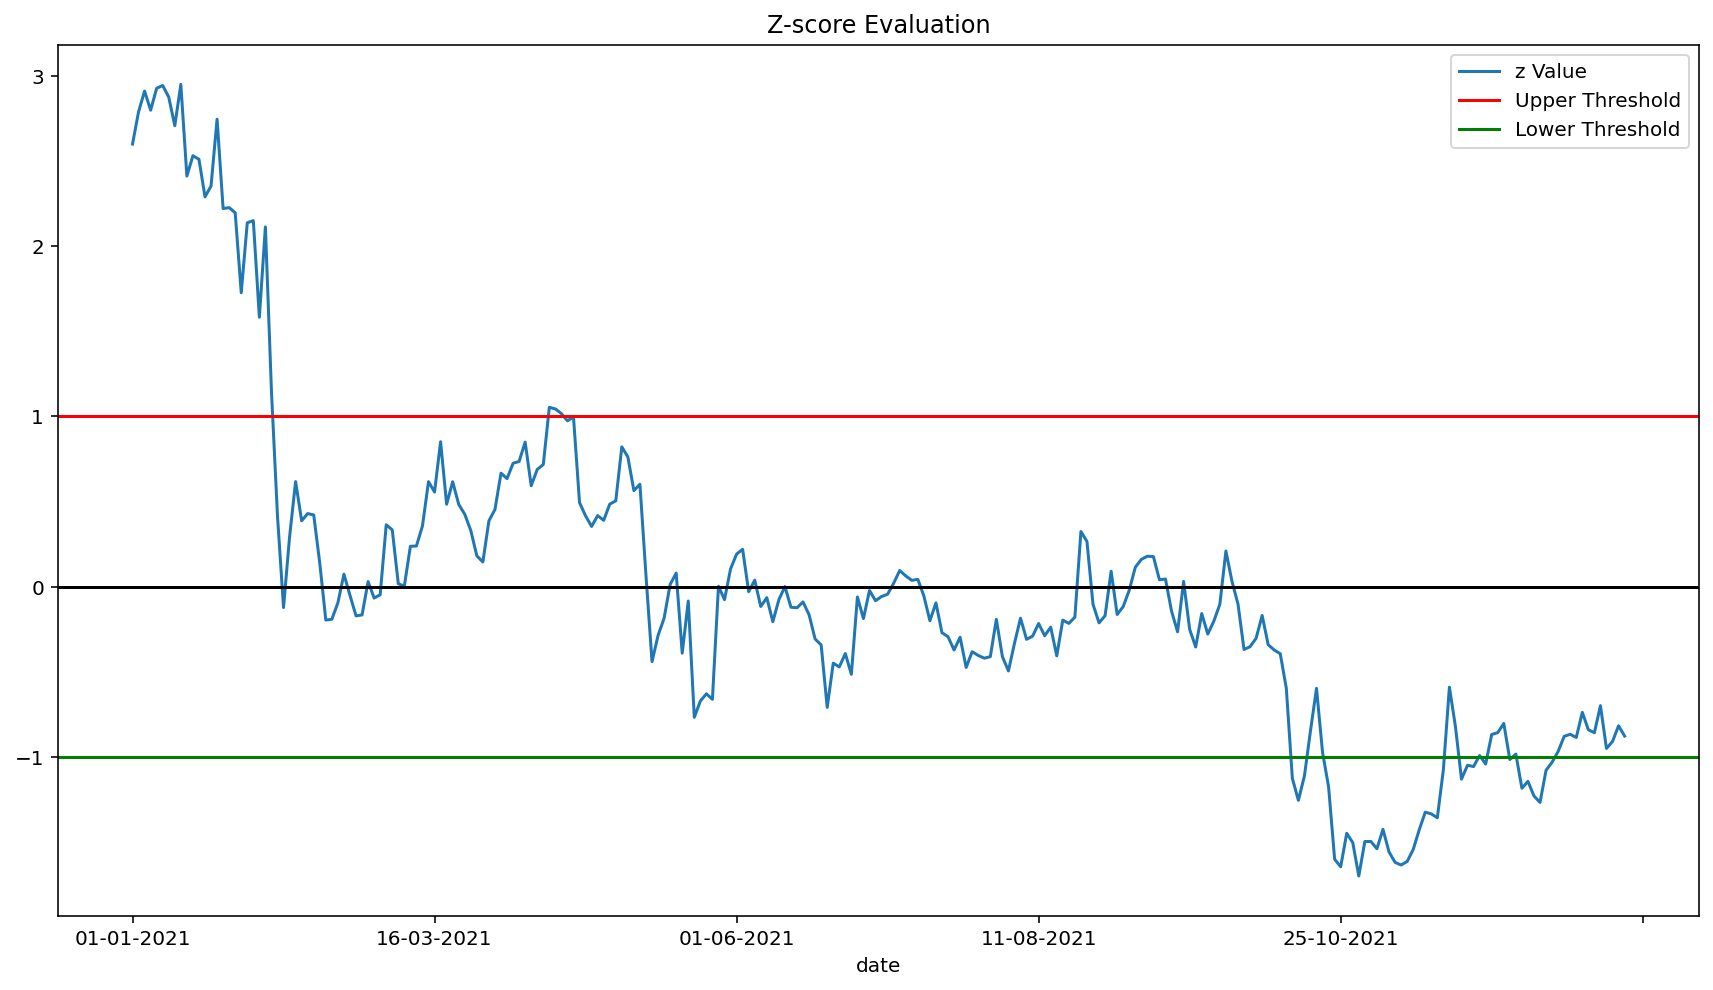

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  34.799999   88.349998  2.598503            1.0           -1.0   
04-01-2021  35.549999   88.699997  2.787790            1.0           -1.0   
05-01-2021  35.599998   87.849998  2.909762            1.0           -1.0   
29-12-2021  37.150002  139.649994 -0.908595            1.0           -1.0   
30-12-2021  37.150002  137.899994 -0.816001            1.0           -1.0   
31-12-2021  37.299999  139.600006 -0.876512            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
01-01-2021  34.799999  88.349998  2.598503            1.0           -1.0   
04-01-2021  35.549999  88.699997  2.787790            1.0           -1.0   
05-01-2021  35.599998  87.849998  2.909762            1.0           -1.0   
06-01-2021  35.200001  87.750000  2.797401            1.0           -1.0   
07-01-2021  35.450001  87.349998  2.926285            1.0           -1.0   
08-01-2021  35.400002  87.099998  2.942490            1.0           -1.0   
11-01-2021  34.900002  86.400002  2.874079            1.0           -1.0   
12-01-2021  36.500000  91.750000  2.706356            1.0           -1.0   
13-01-2021  36.599998  90.000000  2.948997            1.0           -1.0   
14-01-2021  37.000000  95.599998  2.410384            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
08-01-2021        -1         0.0         1         0.0  
11-01-2021        -1         0.0         1         0.0  
12-01-2021        -1         0.0         1         0.0  
13-01-2021        -1         0.0         1         0.0  
14-01-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  34.799999   88.349998  2.598503            1.0           -1.0   
05-02-2021  40.150002  127.750000  0.415175            1.0           -1.0   
15-04-2021  34.750000  102.949997  1.053061            1.0           -1.0   
20-04-2021  33.700001  100.699997  0.973929            1.0           -1.0   
12-10-2021  41.250000  159.800003 -1.124921            1.0           -1.0   
01-12-2021  38.349998  143.350006 -0.867322            1.0           -1.0   
06-12-2021  38.000000  144.949997 -1.014545            1.0           -1.0   
07-12-2021  38.500000  146.199997 -0.982221            1.0           -1.0   
08-12-2021  39.349998  153.699997 -1.182985            1.0           -1.0   
16-12-2021  39.400002  149.300003 -0.966853            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
05-02-2021         0         1.0         0        -1.0  
15-04-2021        -1        -1.0         1         1.0  
20-04-2021         0         1.0         0        -1.0  
12-10-2021         1         1.0        -1        -1.0  
01-12-2021         0        -1.0         0         1.0  
06-12-2021         1         1.0        -1        -1.0  
07-12-2021         0        -1.0         0         1.0  
08-12-2021         1         1.0        -1        -1.0  
16-12-2021         0        -1.0         0         1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

40.150002    1
33.700001    1
41.250000    1
44.650002    1
40.450001    1
37.299999    1
38.000000    1
39.349998    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  34.799999   88.349998  2.598503            1.0           -1.0   
04-01-2021  35.549999   88.699997  2.787790            1.0           -1.0   
05-01-2021  35.599998   87.849998  2.909762            1.0           -1.0   
06-01-2021  35.200001   87.750000  2.797401            1.0           -1.0   
07-01-2021  35.450001   87.349998  2.926285            1.0           -1.0   
...               ...         ...       ...            ...            ...   
27-12-2021  37.250000  136.100006 -0.698124            1.0           -1.0   
28-12-2021  37.299999  141.000000 -0.949277            1.0           -1.0   
29-12-2021  37.150002  139.649994 -0.908595            1.0           -1.0   
30-12-2021  37.150002  137.899994 -0.816001            1.0           -1.0   
31-12-2021  37.299999  139.600006 -0.876512            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

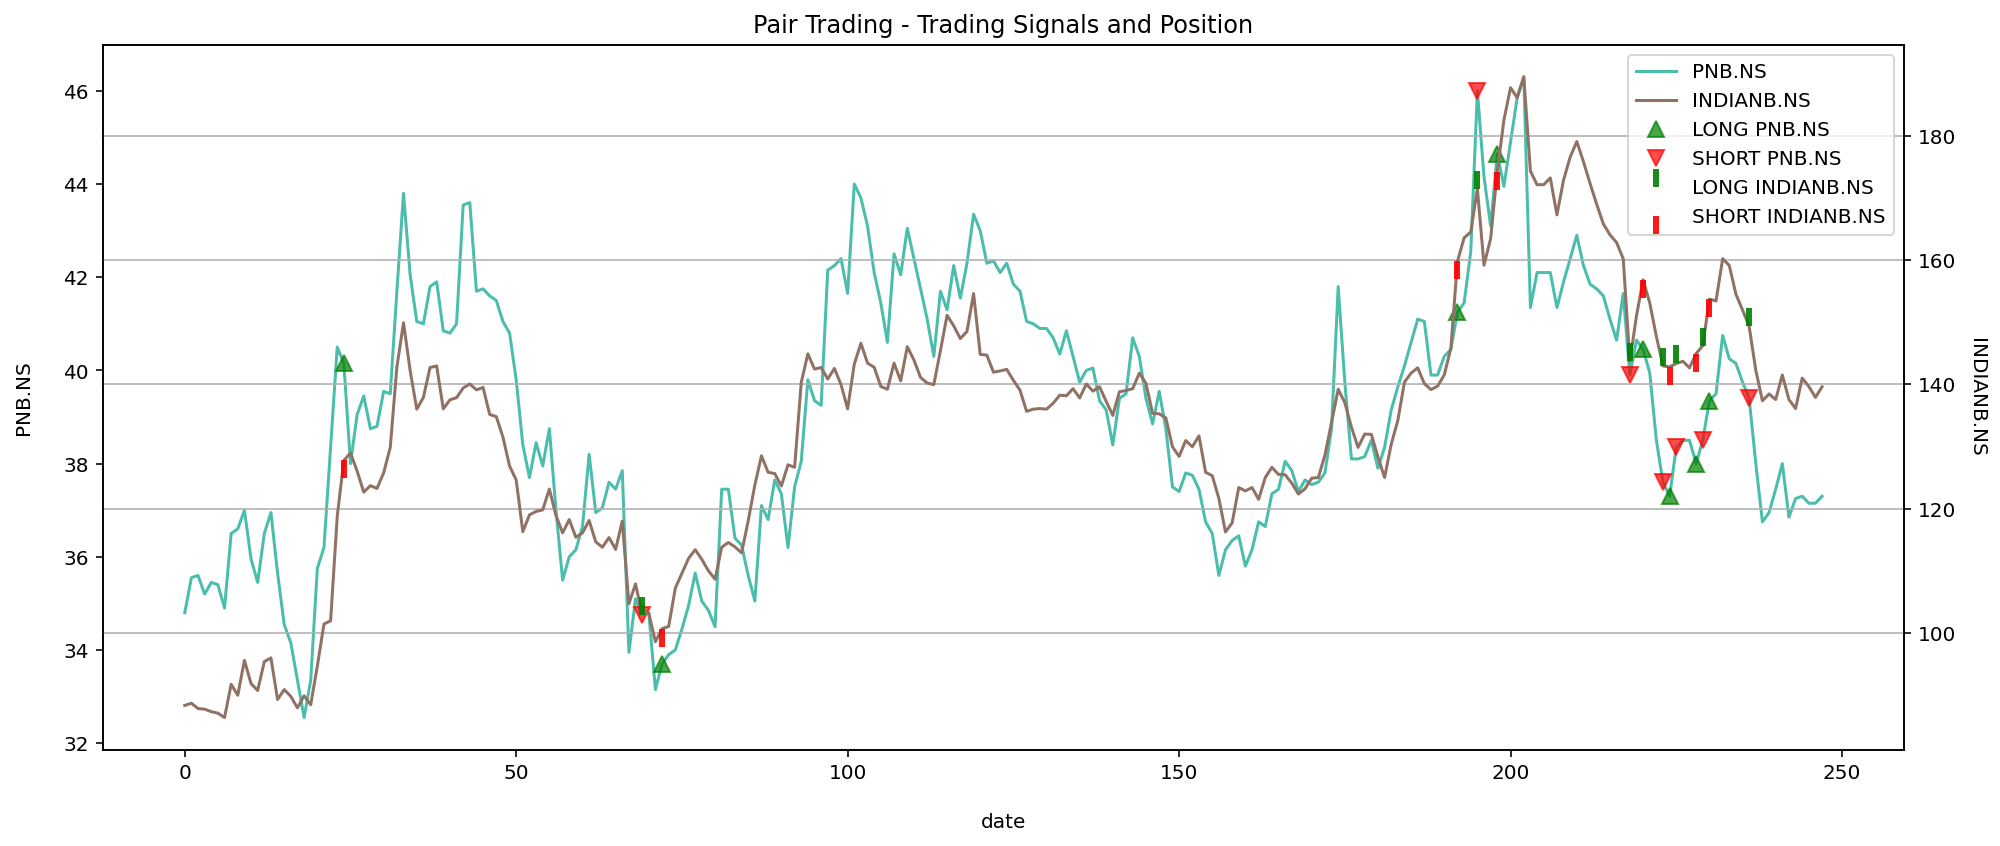

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    34.799999           NaN            NaN            NaN       NaN   
1    35.549999      0.000000  100000.000000  100000.000000       NaN   
2    35.599998      0.000000  100000.000000  100000.000000  0.000000   
3    35.200001      0.000000  100000.000000  100000.000000  0.000000   
4    35.450001      0.000000  100000.000000  100000.000000  0.000000   
243  37.250000  80422.750000   12884.345056   93307.095056  0.009342   
244  37.299999  80530.698359   12884.345056   93415.043415  0.001157   
245  37.150002  80206.853303   12884.345056   93091.198359 -0.003467   
246  37.150002  80206.853303   12884.345056   93091.198359  0.000000   
247  37.299999  80530.698359   12884.345056   93415.043415  0.003479   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1      holdings1         cash1   total asset1   return1  \
0    34.799999            NaN           NaN            NaN       NaN   
24   40.150002   86683.853303  13316.146697  100000.000000  0.000000   
69   34.750000       0.000000  88341.396697   88341.396697 -0.008481   
72   33.700001   72758.301641  15583.095056   88341.396697  0.000000   
192  41.250000  178117.500000 -73475.654944  104641.845056  0.016783   

     positions1  
0           NaN  
24          1.0  
69         -1.0  
72          1.0  
192         1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    34.799999           NaN            NaN            NaN       NaN   
1    35.549999      0.000000  100000.000000  100000.000000       NaN   
2    35.599998      0.000000  100000.000000  100000.000000  0.000000   
3    35.200001      0.000000  100000.000000  100000.000000  0.000000   
4    35.450001      0.000000  100000.000000  100000.000000  0.000000   
243  37.250000  80422.750000   12884.345056   93307.095056  0.009342   
244  37.299999  80530.698359   12884.345056   93415.043415  0.001157   
245  37.150002  80206.853303   12884.345056   93091.198359 -0.003467   
246  37.150002  80206.853303   12884.345056   93091.198359  0.000000   
247  37.299999  80530.698359   12884.345056   93415.043415  0.003479   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN   88.349998           NaN            NaN            NaN   
1           0.0   88.699997      0.000000  100000.000000  100000.000000   
2           0.0   87.849998      0.000000  100000.000000  100000.000000   
3           0.0   87.750000      0.000000  100000.000000  100000.000000   
4           0.0   87.349998      0.000000  100000.000000  100000.000000   
243         0.0  136.100006 -71724.703215  184741.601686  113016.898472   
244         0.0  141.000000 -74307.000000  184741.601686  110434.601686   
245         0.0  139.649994 -73595.546785  184741.601686  111146.054901   
246         0.0  137.899994 -72673.296785  184741.601686  112068.304901   
247         0.0  139.600006 -73569.203215  184741.601686  111172.398472   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.006807         0.0  
244 -0.022849         0.0  
245  0.006442         0.0  
246  0.008298         0.0  
247 -0.007994         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1      holdings1         cash1   total asset1   return1  \
0    34.799999            NaN           NaN            NaN       NaN   
24   40.150002   86683.853303  13316.146697  100000.000000  0.000000   
69   34.750000       0.000000  88341.396697   88341.396697 -0.008481   
72   33.700001   72758.301641  15583.095056   88341.396697  0.000000   
192  41.250000  178117.500000 -73475.654944  104641.845056  0.016783   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN   88.349998            NaN            NaN            NaN   
24          1.0  127.750000  -67324.250000  167324.250000  100000.000000   
69         -1.0  102.949997       0.000000  113069.601634  113069.601634   
72          1.0  100.699997  -53068.898366  166138.500000  113069.601634   
192         1.0  159.800003 -168429.203267  250353.101634   81923.898366   

      return2  positions2  
0         NaN         NaN  
24   0.000000        -1.0  
69   0.023616         1.0  
72   0.000000        -1.0  
192 -0.082619        -1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

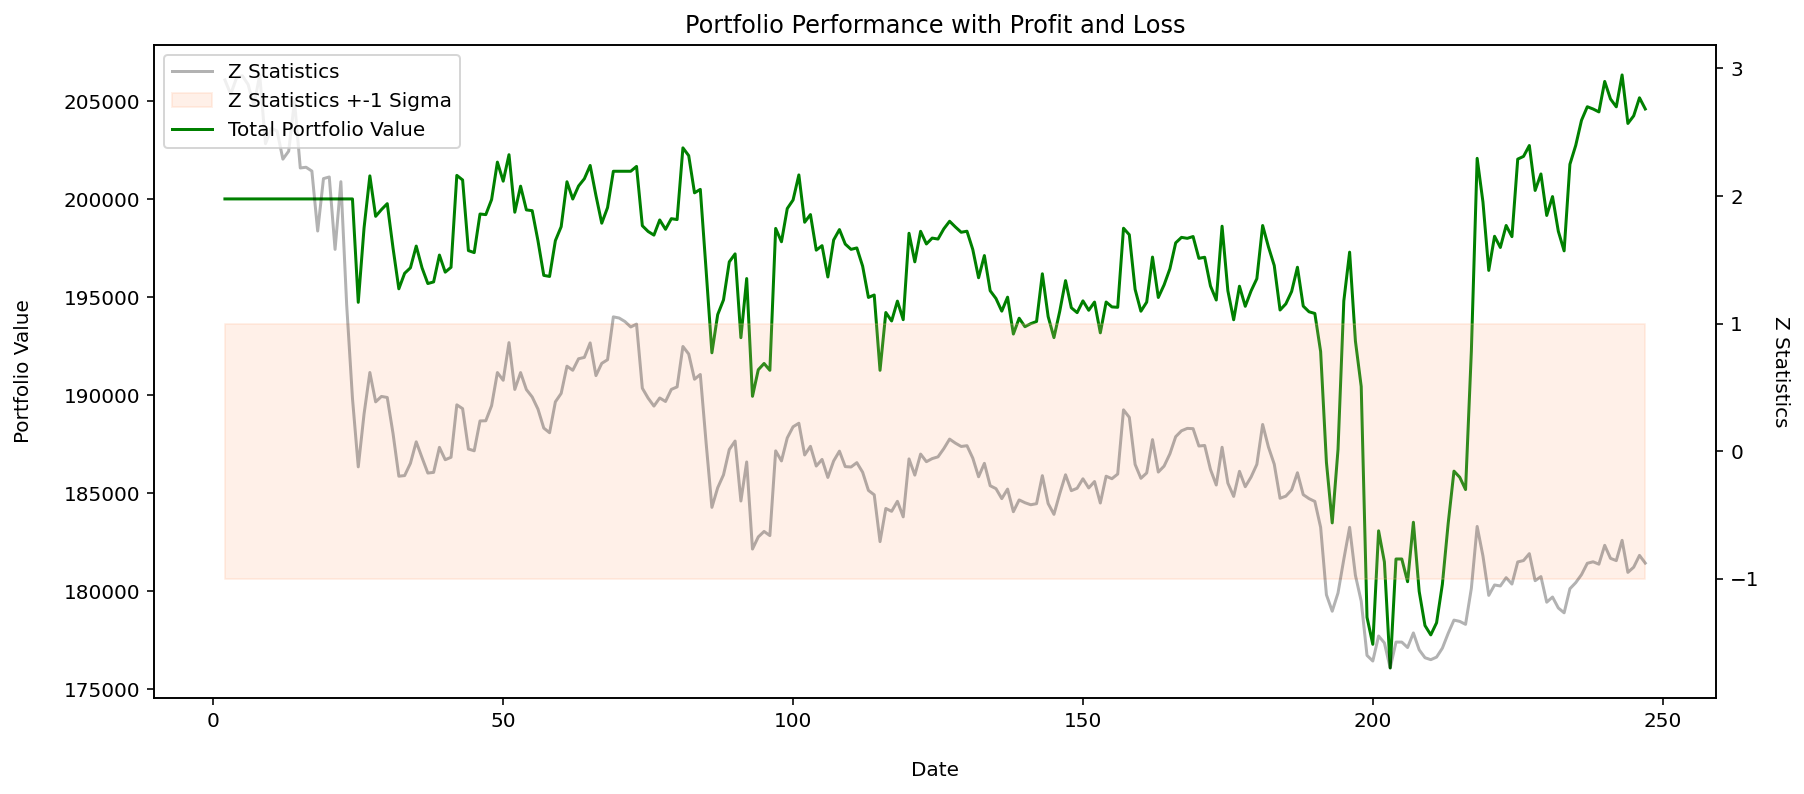

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

204587.44188675005

In [48]:
profit = final_portfolio - 2*initial_capital
profit

4587.44188675005

In [49]:
roi = (profit/(2*initial_capital))*100
roi

2.293720943375025

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 190.500%
